# SMS Spam Generation
ref: 

*  https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms/notebook
*   https://github.com/kokkoks/thai-joke-sentence-generator/blob/main/Text_Generation_using_LSTMs.ipynb






In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os, pathlib, shutil, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D, TextVectorization
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
!curl 'https://raw.githubusercontent.com/khunaitp/SMSGenerator/main/sms_fi.txt' > sms_fi.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  148k  100  148k    0     0   566k      0 --:--:-- --:--:-- --:--:--  564k


In [3]:
# โหลดไฟล์ spam sms
f = open('sms_fi.txt', 'r', encoding='utf-8')
content = f.read()
#print(content)
f.close()

In [4]:
print(len(content))

71697


In [5]:
sms_messages = []
with open('sms_fi.txt', 'r') as f:
    for line in f:
        sms_messages.append(line.strip())
#print(sms_messages)
print(len(sms_messages))

1007


Prepare Text

In [6]:
# ลบลิ้งค์ ลบเบอร์โทร ช่องทางที่ติดต่อที่ unique ทีจะไม่ generate ออกมา
import re
c_sms = [re.sub(r"(http|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", "", i) for i in sms_messages]
c_sms = [re.sub(r"BankokIbank.com", "", i) for i in c_sms]
c_sms = [re.sub(r"thai-life-az.com", "", i) for i in c_sms]
c_sms = [re.sub(r"\s*(dxdk33.vip|tinyurl.com|orll.cc|scb77.cc|gt166.me|bit.ly|Bit.ly|citly.me)/\S*(\s+|$)", "", i) for i in c_sms]
c_sms = [re.sub(r"\s*(cuttt.ly|rb.gy|oline.me|line.me|bit.do|c0c.me|org|lnnk.in|orll.ccl|zhort.link)/\S*(\s+|$)", "", i) for i in c_sms]
c_sms = [re.sub(r"\s*(shortcut.asia|dxdk33.vip|cut.ly|cutt.ly|shorturl.asia|u.to)/\S+(\s+|$)", "", i) for i in c_sms]
c_sms = [re.sub(r"\s*(tiny.cc|bitly.ws|1th.me)/\S*(\s+|$)", "", i) for i in c_sms]
c_sms = [re.sub(r"\s*(http|https)://(\s+|$)", "", i) for i in c_sms]
c_sms = [re.sub(r"(www|scb|shopee1-line|scb77|pxj6666)?\.\w+\.(com|me|co|cc|org|net)\/*\w*", "", i) for i in c_sms]
c_sms = [re.sub(r"\w+\.(com|me|co|cc|org|net)", "", i) for i in c_sms]

c_sms = [re.sub(r"bit.:", "", i) for i in c_sms]
c_sms = [re.sub(r"citibank-01", "", i) for i in c_sms]
c_sms = [re.sub(r"cutt.ly/", "", i) for i in c_sms]
c_sms = [re.sub(r"06523541797", "", i) for i in c_sms]
c_sms = [re.sub(r"thxhkh.cn", "", i) for i in c_sms]
c_sms = [re.sub(r"02-0290099", "", i) for i in c_sms]
c_sms = [re.sub(r"dxdk33.vip", "", i) for i in c_sms]

c_sms = [re.sub(r"(@LINE)\s*:\s*[@a-zA-Z0-9]+", "@LINE:", i) for i in c_sms] # @LINE: mm242, @LINE:ijfoSD3
c_sms = [re.sub(r"(LINE：)\s*[@a-zA-Z0-9]+", "LINE：", i) for i in c_sms] # @LINE: mm242, @LINE:ijfoSD3
c_sms = [re.sub(r"(LINE:)\s*[@a-zA-Z0-9]+", "LINE:", i) for i in c_sms] # @LINE: mm242, @LINE:ijfoSD3
c_sms = [re.sub(r"(Line:)\s*[@a-zA-Z0-9]+", "Line:", i) for i in c_sms]
c_sms = [re.sub(r"(line)\s*:\s*[@a-zA-Z0-9]+", "line:", i) for i in c_sms]
c_sms = [re.sub(r"(@LineID：)\s*[@a-zA-Z0-9]+", "@LineID：", i) for i in c_sms]
c_sms = [re.sub(r"(Line：)\s*[@a-zA-Z0-9]+", "Line：", i) for i in c_sms]
c_sms = [re.sub(r"(Line : )\s*[@a-zA-Z0-9]+", "Line : ", i) for i in c_sms]
c_sms = [re.sub(r"(ID : )\s*[@a-zA-Z0-9]+", "ID : ", i) for i in c_sms]
c_sms = [re.sub(r"(ID:)\s*[@a-zA-Z0-9]+", "ID:", i) for i in c_sms]

c_sms = [re.sub(r"[0]\d{8,9}", "Line：", i) for i in c_sms]
c_sms = [re.sub(r"(\+\d{1,3}\s?)?((\(\d{3}\)\s?)|(\d{3})(\s|-?))(\d{3}(\s|-?))(\d{4})(\s?(([E|e]xt[:|.|]?)|x|X)(\s?\d+))?", "", i) for i in c_sms] # Tel number

In [7]:
# แก้คำผิด เพื่อให้ตัดคำและเรียนรู้ได้ถูกต้อง แก้เฉพาะคำที่ไม่ได้ตั้งใจผิด
c_sms = [re.sub(r"สิท ธิ์", "สิทธิ์", i) for i in c_sms]
c_sms = [re.sub(r"ยิ นดี", "ยินดี", i) for i in c_sms]
c_sms = [re.sub(r"ค ลิ๊ก", "คลิ๊ก", i) for i in c_sms]
c_sms = [re.sub(r"คุ ณ", "คุณ", i) for i in c_sms]
c_sms = [re.sub(r"ก าลัง", "กำลัง", i) for i in c_sms]
c_sms = [re.sub(r"ท า", "ทำ", i) for i in c_sms]
c_sms = [re.sub(r"เชื่ อ", "เชื่อ", i) for i in c_sms]
c_sms = [re.sub(r"S C B", "SCB", i) for i in c_sms]
c_sms = [re.sub(r"【", "[", i) for i in c_sms]
c_sms = [re.sub(r"】", "]", i) for i in c_sms]
c_sms = [re.sub(r"：", ":", i) for i in c_sms]
c_sms = [re.sub(r"»", "", i) for i in c_sms]
c_sms = [re.sub(r"“", "", i) for i in c_sms]
c_sms = [re.sub(r"”", "", i) for i in c_sms]
c_sms = [re.sub(r"☞", "", i) for i in c_sms]
c_sms = [re.sub(r"，", "", i) for i in c_sms]

In [8]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [9]:
c_sms = [emoji_pattern.sub(r'', i) for i in c_sms]

In [10]:
c_sms = [re.sub(r"\d+\s*[%]", "PERCENTAGE", i) for i in c_sms]

In [11]:
"""def to_amount(sms):

  # mask COVID-19
  sms = [re.sub(r"COVID-19", "COVID-NINETEEN", i) for i in sms]

  sms = [re.sub(r",", "", i) for i in sms]
  pattern = r'\d+(\.\d{2})?'
  matches = []
  for item in sms:
    digit_matches = re.findall(pattern, item)
    for match in digit_matches:
      matches.append(match)
  new_sms = [re.sub(pattern, "AMOUNT", i) for i in sms]
  new_sms = [re.sub("COVID-NINETEEN", "COVID-19", i) for i in new_sms]

  return new_sms, matches"""

'def to_amount(sms):\n\n  # mask COVID-19\n  sms = [re.sub(r"COVID-19", "COVID-NINETEEN", i) for i in sms]\n\n  sms = [re.sub(r",", "", i) for i in sms]\n  pattern = r\'\\d+(\\.\\d{2})?\'\n  matches = []\n  for item in sms:\n    digit_matches = re.findall(pattern, item)\n    for match in digit_matches:\n      matches.append(match)\n  new_sms = [re.sub(pattern, "AMOUNT", i) for i in sms]\n  new_sms = [re.sub("COVID-NINETEEN", "COVID-19", i) for i in new_sms]\n\n  return new_sms, matches'

In [12]:
import string

c_sms = [''.join(char for char in item if char not in string.punctuation) for item in c_sms] 

In [13]:
c_sms[:500]

['คุณได้รับสิทธิ์ยื่น ขอGSBออมสิน60000คลิ๊ก',
 'คุณได้รับเงินช่วยเหลือ 24500 สมัครเพื่อรับ',
 'ดอกเบี้ยเฉลี่ย 10000 ละ 35 บาทต่อวันท ',
 'ยื่นขอสินเชื่อGSBออมสิน60000คลิ๊ก',
 'คุณได้สินเชื่อประชารัฐกู้ดอกเบี้ยต่ำสู้ภัยโควิด คลิก ',
 'คุณได้รับสิทธิ์ยืนขอสินเชื่อGSBออมสิน60000 คลิ๊ก',
 'KTBเงินด่วนคุยง่ายยื่นได้ 5 แสนบาท คลิ๊ก',
 'SCBให้โอกาสคุณยื่นกู้100000 คลิ๊ก',
 'KTBคุณได้สิทธิ์ยื่นกู้ 60000บาท คลิ๊ก ',
 'SCBท่านได้รับสิทธิ์ยื่นกู้ 500000ผ่านทางเรา',
 'คุณได้สิทธิ์รับสิน เชื่อGSBออมสิน55000บคลิ๊ก',
 'KBankคุณได้รับสิทธิ์ยื่นกู้ 100000 คลิ๊ก ',
 'KBANK คุณได้รับสิทธิ์ยื่นกู้ 300000 คลิ๊ก',
 'KBANK คุณได้รับสิทธิ์ยื่นกู้ 1000000 คลิ๊ก',
 'SCB คุณได้รับสิทธิ์ยื่นกู้ 50000 บาท แอดไลน์ ',
 'CMBปล่อยกู้ 100000 บาท 100 สิทธิ์ คลิ๊ก ',
 'คุณได้ทุนสำรองประชารัฐ 85OO0 คลิก',
 'เงินเดือน38300ด้เข้าบัญชีของท่านแล้ว คลิกลิงค์',
 'คุณได้รับทุนสำรองโครงการประชารัฐ55000คลิ๊ก',
 'KBANKคุณได้สิทธิ์ยื่นกู้100000ติดต่อ',
 'PROMISEคุณสามารถยื่นได้50000 ผ่านทางเรา',
 'PROMISEสมัครลงทะเบียนวันนี้ อนุมัติ

Tokenization

In [14]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 49.7 MB/s eta 0:00:00


In [15]:
import pythainlp
from pythainlp import tokenize
from pythainlp.corpus.common import thai_words
from pythainlp.util import dict_trie
import string

In [16]:
# tokenize the text data
tokens = [tokenize.word_tokenize(x) for x in c_sms]

In [17]:
dictTH = set(thai_words())
#dictTH.add('โครงการประชารัฐ')
dictTH.add('โครงการ')
dictTH.add('ประชารัฐ')
dictTH.add('ยูส')
dictTH.add('คลิ๊ก')
dictTH.add('ไทยพาณิชย์')
#dictTH.add('โครงการธนาคารประชาชน')
#dictTH.add('โครงการธนาคารเพื่อประชาชน')
#dictTH.add('โครงการเราชนะ')
dictTH.add('เราชนะ')
dictTH.add('ธนาคารประชาชน')
dictTH.add('ธนาคารเพื่อประชาชน')
dictTH.add('เกียรตินาคิน')
dictTH.add('Paotang')
dictTH.add('การดำเนินการ')
dictTH.add('ซิงเกอร์')
dictTH.add('เบราเซอร์')
dictTH.add('โครงการ')
dictTH.add('สิท')
dictTH.add('เคร')
dictTH.add('เทอโบ')
dictTH.add('ผดุงพงษ์')
dictTH.add('คุน')
dictTH.add('nู้')
dictTH.add('เพื่v')
dictTH.add('รัu')
dictTH.add('iลย')
dictTH.add('iหลือ')
dictTH.add('คนละครึ่ง')
dictTH.add('รีเช็ต')
dictTH.add('ไทยประกันชีวิต')
dictTH.add('ธกส')
dictTH.add('เป๋าตัง')
dictTH.add('สิริวรรณ')
dictTH.add('ปุ๊กสันเทียะ')
dictTH.add('ชนิกานต์')
dictTH.add('ลือดารา')
dictTH.add('โสภิตา')
dictTH.add('สมคิด')
dictTH.add('ถนอมวำ')
dictTH.add('มีเหรียญ')
dictTH.add('มนัสชนก')
dictTH.add('เสนาชัย')
dictTH.add('ยิ่งยืน')
dictTH.add('อรุณกมล')
dictTH.add('โรจนจิรพันธ์')
dictTH.add('สุชาติ')
dictTH.add('ดีการนา')
dictTH.add('ชัชวาลย์')
dictTH.add('จันทร์หอม')
dictTH.add('เทอร์โบมันนี่')
dictTH.add('กสิกรไทย')
dictTH.add('set')
dictTH.add('free')
dictTH.add('sms')
dictTH.add('ชัช')
dictTH.add('กด')
dictTH.add('โคตา')
dictTH.add('โคต้า')
dictTH.add('โทร')
dictTH.add('นินันย์')
dictTH.add('ปรึงปี่')
dictTH.add('เซอร์ไฟรส์')
dictTH.add('แอป')
dictTH.add('COVID19')
dictTH.add('คลี้ก')
dictTH.add('MyMo')
dictTH.add('GS8')
dictTH.add('ปัญญาเบิง')
dictTH.add('ตัวตน')
dictTH.add('ยินดีด้วย')
dictTH = dict_trie(dict_source=dictTH)

tokens = [tokenize.word_tokenize(x, custom_dict=dictTH, keep_whitespace=False) for x in c_sms]
#tokens

In [18]:
tokens[100:250]

[['ขอแสดงความยินดี', 'ท่าน', 'ได้รับ', 'วง', 'เงินกู้', 'ยืม', '300000'],
 ['แอด',
  'เพื่อ',
  'รับ',
  'วง',
  'เงินกู้',
  '85000',
  'วงเงิน',
  'เครดิต',
  'ธนาคาร'],
 ['แอด',
  'เพื่อ',
  'รับ',
  'วง',
  'เงินกู้',
  '80000',
  'วงเงิน',
  'เครดิต',
  'ธนาคาร'],
 ['รับ', 'สิทธิ์', 'สินเชื่อ', 'เงิน', 'ด่วน', '180000', 'บาท'],
 ['เงินเดือน', '1000', 'บาท', 'โอน', 'เข้าบัญชี', 'เรียบร้อย'],
 ['คุณ', 'ได้', 'สิทธิ์', 'สินเชื่อ', 'วงเงิน', '200000', 'บาท'],
 ['ขอแสดงความยินดี', 'ท่าน', 'ได้รับ', 'วงเงิน', 'กู้ยืม', '300000'],
 ['ยินดีด้วย', 'คุณ', 'ได้รับ', 'การอนุมัติ', 'ด้วย', 'จำนวน', '300000'],
 ['แจ้ง', 'เงินช่วยเหลือ', '1000', 'บาท', 'เพื่อ', 'รับ'],
 ['คุน', 'ได้รับ', 'สินเชื่อ', 'จาก', 'ทาง', 'เรา', 'คลิ๊ก'],
 ['ขอแสดงความยินดี', 'ท่าน', 'ได้รับ', 'วงเงิน', 'กู้ยืม', '300000'],
 ['ขอแสดงความยินดี', 'ท่าน', 'ได้รับ', 'วงเงิน', 'กู้ยืม', '300000'],
 ['คุณ',
  'ได้รับ',
  'สิทธิ์',
  'ยื่น',
  'กู้',
  'กับ',
  'KBANK',
  '88000',
  'บาท',
  'คลิ๊ก'],
 ['คุณ',
  'ได้รับ',
  '20

In [19]:
# เพิ่มตัวจบประโยค (END)
for i in range(len(tokens)):
  tokens[i].append('END')

print(tokens[:5])

[['คุณ', 'ได้รับ', 'สิทธิ์', 'ยื่น', 'ขอ', 'GSB', 'ออมสิน', '60000', 'คลิ๊ก', 'END'], ['คุณ', 'ได้รับ', 'เงินช่วยเหลือ', '24500', 'สมัคร', 'เพื่อ', 'รับ', 'END'], ['ดอกเบี้ย', 'เฉลี่ย', '10000', 'ละ', '35', 'บาท', 'ต่อ', 'วัน', 'ท', 'END'], ['ยื่น', 'ขอ', 'สินเชื่อ', 'GSB', 'ออมสิน', '60000', 'คลิ๊ก', 'END'], ['คุณ', 'ได้', 'สินเชื่อ', 'ประชารัฐ', 'กู้', 'ดอกเบี้ย', 'ต่ำ', 'สู้', 'ภัย', 'โควิด', 'คลิก', 'END']]


In [20]:
processed_sentence = []
for i in range(len(tokens)):
  sentence = " ".join(tokens[i])
  processed_sentence.append(sentence)

print(len(processed_sentence))
print(processed_sentence[:5])

1007
['คุณ ได้รับ สิทธิ์ ยื่น ขอ GSB ออมสิน 60000 คลิ๊ก END', 'คุณ ได้รับ เงินช่วยเหลือ 24500 สมัคร เพื่อ รับ END', 'ดอกเบี้ย เฉลี่ย 10000 ละ 35 บาท ต่อ วัน ท END', 'ยื่น ขอ สินเชื่อ GSB ออมสิน 60000 คลิ๊ก END', 'คุณ ได้ สินเชื่อ ประชารัฐ กู้ ดอกเบี้ย ต่ำ สู้ ภัย โควิด คลิก END']


In [21]:
tokenizer = Tokenizer(lower=False)

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    """
    the greatest token ID in word_index is len(word_index). Therefore, 
    we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID.
    """
    # https://datascience.stackexchange.com/questions/93651/reason-for-adding-1-to-word-index-for-sequence-modeling
    total_words = len(tokenizer.word_index) + 1 # 731
    

    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

In [22]:
inp_sequences, total_words = get_sequence_of_tokens(processed_sentence)
inp_sequences[:10]

[[2, 3],
 [2, 3, 5],
 [2, 3, 5, 8],
 [2, 3, 5, 8, 54],
 [2, 3, 5, 8, 54, 48],
 [2, 3, 5, 8, 54, 48, 38],
 [2, 3, 5, 8, 54, 48, 38, 95],
 [2, 3, 5, 8, 54, 48, 38, 95, 9],
 [2, 3, 5, 8, 54, 48, 38, 95, 9, 1],
 [2, 3]]

In [23]:
tokenizer.sequences_to_texts(inp_sequences[:10])

['คุณ ได้รับ',
 'คุณ ได้รับ สิทธิ์',
 'คุณ ได้รับ สิทธิ์ ยื่น',
 'คุณ ได้รับ สิทธิ์ ยื่น ขอ',
 'คุณ ได้รับ สิทธิ์ ยื่น ขอ GSB',
 'คุณ ได้รับ สิทธิ์ ยื่น ขอ GSB ออมสิน',
 'คุณ ได้รับ สิทธิ์ ยื่น ขอ GSB ออมสิน 60000',
 'คุณ ได้รับ สิทธิ์ ยื่น ขอ GSB ออมสิน 60000 คลิ๊ก',
 'คุณ ได้รับ สิทธิ์ ยื่น ขอ GSB ออมสิน 60000 คลิ๊ก END',
 'คุณ ได้รับ']

In [24]:
total_words

731

In [25]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors = input_sequences[:,:-1] # as X
    label = input_sequences[:,-1] # as y
    label = tf.keras.utils.to_categorical(label, num_classes=total_words) # one-hot encoded using the to_categorical function
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [26]:
print("Max sequence = ", max_sequence_len)

Max sequence =  47


In [27]:
print(predictors[0])
print(label[0])
print("predictors.shape:", predictors.shape)
print("label.shape", label.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Model

In [28]:
# underfit or overfit 
# underfit
# (1) more GRU layers
# (2) more neurons per layer
# (3) train longer 
# (4) adjust an input pattern that longer than n_steps
# (5) use stateful RNN to handle very long sequences
# overfit
# (1) add some regularization
# (2) add dropout with more dropout rate

In [29]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1 
    # using 1 less value because we are preserving the last value for predicted word
    
    model = Sequential()
    
    # word embedding -> เกิดจากการแปลงจาก one-hot เป็น vector
    # mask zero = tell model to skip processing (ignore 0) these inputs
    model.add(Embedding(total_words, output_dim=64,
                        input_length=input_len, mask_zero=True))
    
    model.add(LSTM(256))
    
    # Softmax over possible vocabulary words, computed for each output sequence timestep.
    model.add(Dense(total_words, activation='softmax'))
    return model


In [30]:
model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 64)            46784     
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 dense (Dense)               (None, 731)               187867    
                                                                 
Total params: 563,355
Trainable params: 563,355
Non-trainable params: 0
_________________________________________________________________


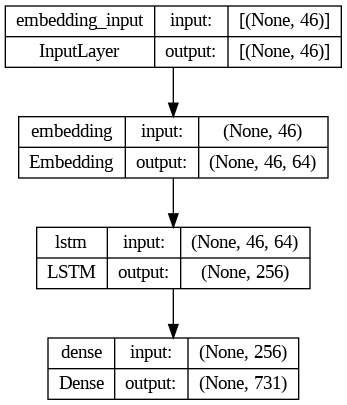

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Model-Type - When training a GAN model, the accuracy change would be low(maximum cases) and an epoch run will consume good amount of GPU. In such cases its better to save checkpoint files after specific number of epochs with a low value of patience. And then use checkpoints to further improve as required. Analyse similarly for other model types.

In [34]:
model.fit(predictors, label, epochs=10, verbose=1)

Epoch 1/10
298/298 [==============================] - 39s 130ms/step - loss: 3.8917
Epoch 2/10
298/298 [==============================] - 39s 133ms/step - loss: 3.3563
Epoch 3/10
298/298 [==============================] - 38s 127ms/step - loss: 2.9043
Epoch 4/10
298/298 [==============================] - 39s 130ms/step - loss: 2.5015
Epoch 5/10
298/298 [==============================] - 38s 127ms/step - loss: 2.1577
Epoch 6/10
298/298 [==============================] - 40s 132ms/step - loss: 1.8690
Epoch 7/10
298/298 [==============================] - 39s 129ms/step - loss: 1.6233
Epoch 8/10
298/298 [==============================] - 39s 130ms/step - loss: 1.4184
Epoch 9/10
298/298 [==============================] - 38s 127ms/step - loss: 1.2516
Epoch 10/10
298/298 [==============================] - 39s 130ms/step - loss: 1.1077


In [35]:
def generate_text(text, model, max_sequence_len):
    seed_text = " ".join(tokenize.word_tokenize(text))
    counter = 0
    while counter < 100:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.random.choice(np.arange(0, predicted.shape[1]), p=predicted[0])

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == "PERCENTAGE":
          p = str(random.randint(1, 10))
          output_word = p + "%"
        seed_text += " "+output_word

        if output_word == "END":
          joined_text = "".join(seed_text.split(" ")[:-1])
          return joined_text
        counter += 1
    return seed_text

In [36]:
test_text = "คุณ"
print(generate_text(test_text, model, max_sequence_len))

คุณสามารถกู้200001000จากทางเราคลิ๊กIDLINE


In [37]:
test_text = "คุณ"
print(generate_text(test_text, model, max_sequence_len))

คุณได้รับสินเชื่อหมุนเวียนสมัคร50000บาทคลิ๊ก


In [38]:
test_text = "เงิน"
print(generate_text(test_text, model, max_sequence_len))

เงินด่วนฉุกเฉินคุยอุปกรณ์เร็วดอกเบี้ยต่ำสนใจแอดไลน์


Save Model

In [39]:
import pickle

model.save("model.h5")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)